### iMPORTAÇÃO DAS BIBLIOTECAS

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### LEITURA DO ARQUIVO E AJUSTE NAS COLUNAS

In [16]:
# LEITURA DO ARQUIVO "BRAIN.CSV"
brain = pd.read_csv('Brain.csv')
# AJUSTE NO NOME DAS COLUNAS PARA MINUSCULO
brain.columns = map(str.lower, brain.columns)

### CRIAÇÃO DE NOVAS FEATURES 

In [17]:
# CRIAÇÃO DE NOVA COLUNA COM A SEGMENTAÇÃO DA IDADE PELO SEXO MASCULINO
brain['homem_acima45'] = [1 if age == 1 and men == 1 else 0 for age, men in zip(brain['acima45'], brain['homem'])]

# CRIAÇÃO DE NOVA COLUNA COM A IDENTIFICAÇÃO DO SEXO FEMININO
brain['mulher'] = [1 if woman == 0 else 0 for woman in brain['homem']]

# CRIAÇÃO DE NOVA COLUNA COM A IDENTIFICAÇÃO GENERO
brain['genero'] = ['F' if gender == 0 else 'M' for gender in brain['homem']]

# CRIAÇÃO DE NOVA COLUNA COM A SEGMENTAÇÃO DA IDADE PELO SEXO FEMININO
brain['mulher_acima45'] = [1 if age == 1 and woman == 1 else 0 for age, woman in zip(brain['acima45'], brain['mulher'])]

# AJUSTE NA ORDEM DAS COLUNAS
brain = brain.reindex(columns=['homem', 'homem_acima45', 'mulher', 'mulher_acima45', 'genero', 'tamanho', 'peso', 'acima45'])

### ANÁLISE DESCRITIVA DOS VALORES DAS COLUNAS "TAMANHO" E "PESO"

In [18]:
brain[['tamanho', 'peso']].describe()

,tamanho,peso
count,237.000000,237.000000
mean,3633.991561,1282.873418
std,365.261422,120.340446
min,2720.000000,955.000000
25%,3389.000000,1207.000000
50%,3614.000000,1280.000000
75%,3876.000000,1350.000000
max,4747.000000,1635.000000


### VISUALIZAÇÃO DA DISTRIBUIÇÃO E CORRELAÇÃO ENTRE AS VARIÁVEIS "TAMANHO" E "PESO"

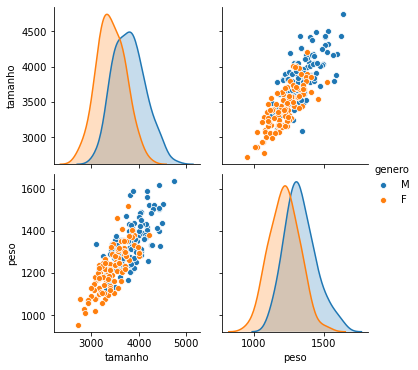

In [21]:
sns.pairplot(brain, vars=['tamanho', 'peso'], hue='genero');